In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from IPython.display import Image, HTML

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [23]:
OutsideApril = pd.read_csv('/home/markn/Desktop/DataSensor/FebData.csv')
OutsideMay = pd.read_csv('/home/markn/Desktop/DataSensor/MarchData.csv')

bigdatasensor = pd.concat([OutsideApril, OutsideMay], ignore_index=True, sort=False)
# bigdatasensor.head()
bigdatasensor = bigdatasensor.rename(columns = {'Date and Time': 'dt', 'PM2.5': 'PM25'}, inplace = False)
bigdatasensor['dt'] = pd.to_datetime(bigdatasensor['dt'])
bigdatasensor.columns = [c.replace(' ', '_') for c in bigdatasensor.columns]

d = bigdatasensor.copy()

In [24]:
d.sort_values('dt', inplace=True)

In [25]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

d["PM2.5_SubIndex"] = d["PM25"].apply(lambda x: get_PM25_subindex(x))

## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

d["NOx_SubIndex"] = d["NO2"].apply(lambda x: get_NOx_subindex(x))

## CO Sub-Index calculation
def get_CO2_subindex(x):
    if x <= 700:
        return x * 50 / 700
    elif x <= 800:
        return 50 + (x - 700) * 50 / 100
    elif x <= 1100:
        return 100 + (x - 800) * 100 / 300
    elif x <= 1500:
        return 200 + (x - 1100) * 100 / 400
    elif x <= 2000:
        return 300 + (x - 1500) * 100 / 500
    elif x > 2000:
        return 400 + (x - 2000) * 100 / 500
    else:
        return 0

d["CO2_SubIndex"] = d["CO2"].apply(lambda x: get_CO2_subindex(x))

def get_TVOCx_subindex(x):
    if x <= 250:
        return x * 50 / 250
    elif x <= 500:
        return 50 + (x - 250) * 50 / 250
    elif x <= 1000:
        return 100 + (x - 500) * 100 / 500
    elif x <= 2500:
        return 200 + (x - 1000) * 100 / 1500
    elif x <= 3000:
        return 300 + (x - 2500) * 100 / 500
    elif x > 3000:
        return 400 + (x - 3000) * 100 / 500
    else:
        return 0

d["TVOCx_SubIndex"] = d["TVOC"].apply(lambda x: get_TVOCx_subindex(x))

def get_Ozonex_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

d["Ozonex_SubIndex"] = d["Ozone"].apply(lambda x: get_Ozonex_subindex(x))



In [26]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe | Danger"
    else:
        return np.NaN

       
   
d["Checks"] = (d["PM2.5_SubIndex"] > 0).astype(int) + \
                        (d["TVOCx_SubIndex"] > 0).astype(int) + \
                        (d["NOx_SubIndex"] > 0).astype(int) + \
                        (d["Ozonex_SubIndex"] > 0).astype(int) + \
                        (d["CO2_SubIndex"] > 0).astype(int)

d["AQI_calculated"] = round(d[["PM2.5_SubIndex", "NOx_SubIndex",
                                  "CO2_SubIndex", "Ozonex_SubIndex", "TVOCx_SubIndex"]].max(axis = 1))
# # d.loc[d["PM2.5_SubIndex"] + d["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
# d.loc[d.Checks < 3, "AQI_calculated"] = np.NaN

d["AQI_bucket_calculated"] = d["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
d[~d.AQI_calculated.isna()].head(13)
       
d.head(10)

,dt,Temperature,Relative_Humidity,PM25,TVOC,CO2,CO,Air_Pressure,Ozone,NO2,Virus_Index,PM2.5_SubIndex,NOx_SubIndex,CO2_SubIndex,TVOCx_SubIndex,Ozonex_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,2021-02-01 09:24:00,7.2,76.5,1,0,712,0,990.6,8.0,19.4,9,1.666667,24.25,56.000000,0.0,10.0,4,56.0,Satisfactory
1,2021-02-01 09:25:00,8.3,72.3,1,0,704,0,990.5,8.0,19.4,9,1.666667,24.25,52.000000,0.0,10.0,4,52.0,Satisfactory
2,2021-02-01 09:26:00,9.1,69.3,1,0,668,0,990.6,8.0,19.4,8,1.666667,24.25,47.714286,0.0,10.0,4,48.0,Good
3,2021-02-01 09:27:00,9.6,67.0,2,0,639,0,990.5,8.0,19.4,8,3.333333,24.25,45.642857,0.0,10.0,4,46.0,Good
4,2021-02-01 09:28:00,9.9,65.2,1,0,618,0,990.6,8.0,19.4,8,1.666667,24.25,44.142857,0.0,10.0,4,44.0,Good
5,2021-02-01 09:29:00,10.2,64.0,1,0,580,0,990.6,8.0,19.4,6,1.666667,24.25,41.428571,0.0,10.0,4,41.0,Good
6,2021-02-01 09:30:00,10.5,63.1,5,0,542,0,990.6,8.0,19.4,6,8.333333,24.25,38.714286,0.0,10.0,4,39.0,Good
7,2021-02-01 09:31:00,10.6,62.4,3,0,525,0,990.6,8.0,19.4,6,5.000000,24.25,37.500000,0.0,10.0,4,38.0,Good
8,2021-02-01 09:32:00,10.8,61.8,9,0,516,0,990.6,8.0,19.4,6,15.000000,24.25,36.857143,0.0,10.0,4,37.0,Good
9,2021-02-01 09:33:00,10.9,61.3,4,0,508,0,990.5,8.0,19.4,6,6.666667,24.25,36.285714,0.0,10.0,4,36.0,Good


In [76]:
AQI = d.copy()

AQI = AQI.drop(['PM25', 'NO2', 'TVOC', 'CO2', 'CO', 'Air_Pressure', 'Ozone', 'AQI_bucket_calculated', 'PM2.5_SubIndex', 'NOx_SubIndex', 'CO2_SubIndex', 'TVOCx_SubIndex', 'Ozonex_SubIndex', 'Checks', 'Virus_Index'], axis=1)

In [77]:
AQI

,dt,Temperature,Relative_Humidity,AQI_calculated
0,2021-02-01 09:24:00,7.2,76.5,56.0
1,2021-02-01 09:25:00,8.3,72.3,52.0
2,2021-02-01 09:26:00,9.1,69.3,48.0
3,2021-02-01 09:27:00,9.6,67.0,46.0
4,2021-02-01 09:28:00,9.9,65.2,44.0
...,...,...,...,...
81469,2021-03-31 23:54:00,24.0,34.1,213.0
81470,2021-03-31 23:55:00,23.9,33.9,213.0
81471,2021-03-31 23:56:00,23.9,34.2,213.0
81472,2021-03-31 23:57:00,23.9,34.0,213.0


In [78]:
# pd.to_datetime(AQI[AQI.columns[0]], format='%Y-%m-%d')
AQI = AQI.rename(columns = {'dt':'Date'})
AQI['Date'] = AQI['Date'].dt.strftime('%Y-%m-%d')

In [79]:
AQI[AQI.columns[0]] = pd.to_datetime(AQI[AQI.columns[0]], format='%Y-%m-%d')
AQI = AQI.set_index(AQI.columns[0])
AQI = AQI.sort_index()
all_station_temp = AQI.astype('float')
all_station_temp.tail()

,Temperature,Relative_Humidity,AQI_calculated
Date,,,
2021-03-31,24.0,34.1,213.0
2021-03-31,23.9,33.9,213.0
2021-03-31,23.9,34.2,213.0
2021-03-31,23.9,34.0,213.0
2021-03-31,23.9,33.9,213.0


In [80]:
# create future forecast dates
def create_dates(start,days):
    v = pd.date_range(start=start, periods=days+1, freq='D', closed='right')
    seven_day_forecast = pd.DataFrame(index=v) 
    return seven_day_forecast

In [81]:
# get values, station name and drop null values
def get_value_name(all_station_temp,i):
    station_value = all_station_temp[[all_station_temp.columns[i]]].dropna()
    station_name = all_station_temp.columns[i]
    return station_value, station_name 

In [82]:
# train-test split for a user input ratio
def train_test_split(value, name, ratio):
    nrow = len(value)
    print(name+' total samples: ',nrow)
    split_row = int((nrow)*ratio)
    print('Training samples: ',split_row)
    print('Testing samples: ',nrow-split_row)
    train = value.iloc[:split_row]
    test = value.iloc[split_row:]
    return train, test, split_row  

In [83]:
# data transformation
def data_transformation(train_tract1,test_tract1):
    scaler = MinMaxScaler()
    train_tract1_scaled = scaler.fit_transform(train_tract1)
    test_tract1_scaled = scaler.fit_transform(test_tract1)          
    train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
    test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled,
                                         index = test_tract1.index, columns=[test_tract1.columns[0]])
    return train_tract1_scaled_df, test_tract1_scaled_df, scaler     

In [84]:
# feature builder - This section creates feature set with lag number of predictors--Creating features using lagged data
def timeseries_feature_builder(df, lag):
    df_copy = df.copy()
    for i in range(1,lag):
        df_copy['lag'+str(i)] = df.shift(i) 
    return df_copy
    df_copy = df.copy()

In [85]:
# preprocessing -- drop null values and make arrays 
def make_arrays(train_tract1,test_tract1):
    X_train_tract1_array = train_tract1.dropna().drop(train_tract1.columns[0], axis=1).values
    y_train_tract1_array = train_tract1.dropna()[train_tract1.columns[0]].values
    X_test_tract1_array = test_tract1.dropna().drop(test_tract1.columns[0], axis=1).values
    y_test_tract1_array = test_tract1.dropna()[test_tract1.columns[0]].values    
    return X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array

In [86]:
# Define LSTM model
def lstm_model(units, trainX, testX, y_train_tract1_array, y_test_tract1_array):
    model = Sequential()
    model.add(LSTM(units,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2]),kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.2))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.2))    
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(1))        
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    
    model.fit(trainX, y_train_tract1_array, batch_size=120, epochs=100, validation_data=(testX, y_test_tract1_array), verbose=0)
    return model

In [87]:
# validation result 
def valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag):    
    testPredict = model.predict(testX)
    rSquare_test = r2_score(y_test_tract1_array, testPredict)
    print('Test R-squared is: %f'%rSquare_test)    
    testPredict = scaler.inverse_transform(testPredict)        
    new_test_tract1 = station_value.iloc[split_row:]       
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    test_tract1_pred['Forecast'] = testPredict
    return test_tract1_pred 

In [88]:
# multi step future forecast for next days number of days. 
def forecast(model, testX, test_tract1, lag, scaler, days):
    seven_days = []
    new0 = testX[-1]        
    last = test_tract1.iloc[-1]
    new_predict = last[0]        
    new_array = np.insert(new0, 0, new_predict)        
    new_array = np.delete(new_array, -1)
    new_array_reshape = np.reshape(new_array, (-1,1,lag))       
    new_predict = model.predict(new_array_reshape)
    temp_predict = scaler.inverse_transform(new_predict) 
    seven_days.append(temp_predict[0][0].round(2))
    
    for i in range(1,days):
        new_array = np.insert(new_array, 0, new_predict)             
        new_array = np.delete(new_array, -1)
        new_array_reshape = np.reshape(new_array, (-1,1,lag))            
        new_predict = model.predict(new_array_reshape)
        temp_predict = scaler.inverse_transform(new_predict) 
        seven_days.append(temp_predict[0][0].round(2))
    return seven_days         

In [89]:
def england_temp_lstm(all_station_temp, lag, days):    
    
    seven_day_forecast_lstm = create_dates('2021-3-30',days) 
    
    for i in range(len(all_station_temp.columns)):
        
        # preprocessing
        station_value, station_name = get_value_name(all_station_temp,i)        
        train_tract1, test_tract1, split_row = train_test_split(station_value, station_name, 0.90)        
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1) 
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df, lag+1) 
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)               
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1, 
                                                                                                           test_tract1)        
        trainX = np.reshape(X_train_tract1_array, (X_train_tract1_array.shape[0],1,X_train_tract1_array.shape[1]))
        testX = np.reshape(X_test_tract1_array, (X_test_tract1_array.shape[0],1,X_test_tract1_array.shape[1]))                
        
        # LSTM modelling & forecast
        model = lstm_model(30, trainX, testX, y_train_tract1_array, y_test_tract1_array)             
        test_tract1_pred = valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag)        
        seven_days = forecast(model, testX, test_tract1, lag, scaler, days)       
        seven_day_forecast_lstm[station_name] = np.array(seven_days)       
        
        # plot result
        plt.figure(figsize=(20,5))       
        plt.plot(seven_day_forecast_lstm[station_name], color='red', label='forecast')         
        plt.ylabel('AirIndex')
        plt.legend(loc='upper right')
        plt.title(station_name + '- April 2021 Air Forecast Quality')
        plt.show()        
        
    return(seven_day_forecast_lstm)

Temperature total samples:  81474
Training samples:  73326
Testing samples:  8148


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.943375


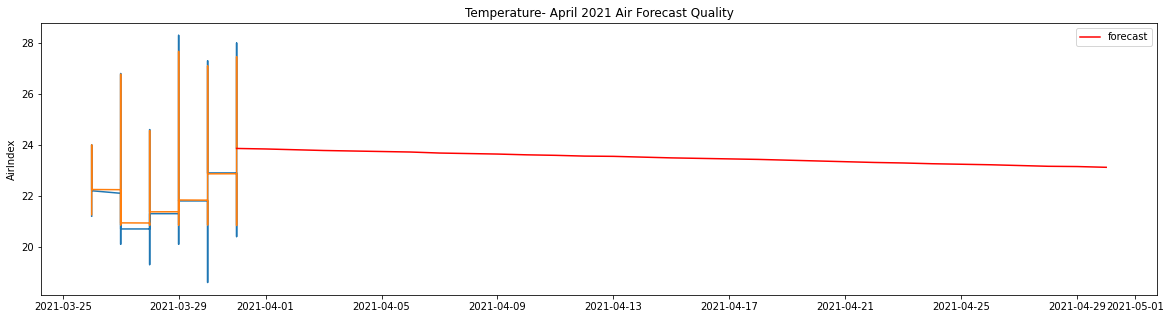

Relative_Humidity total samples:  81474
Training samples:  73326
Testing samples:  8148


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.251482


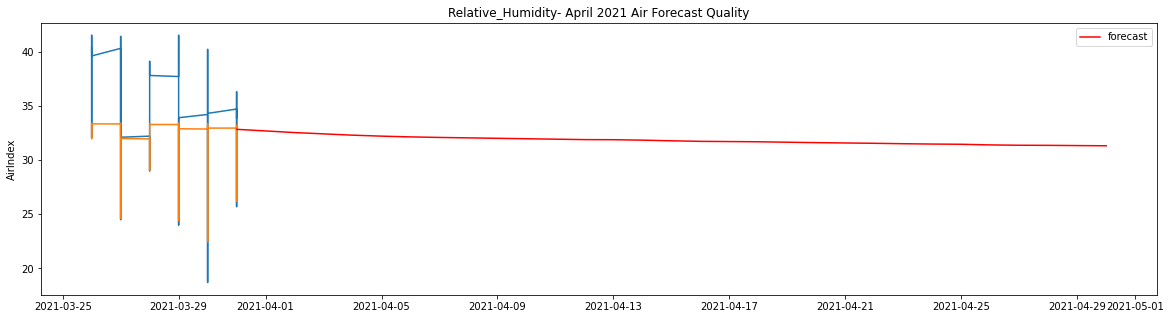

AQI_calculated total samples:  81474
Training samples:  73326
Testing samples:  8148


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.991800


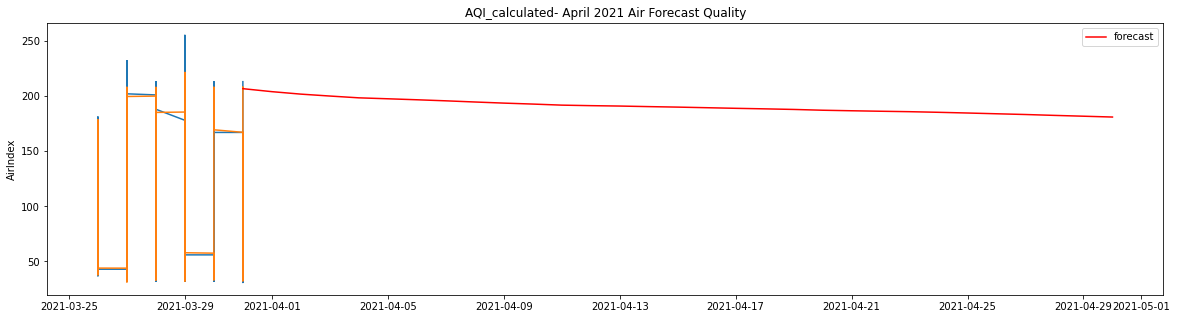

In [90]:
# Fitting and forecast using LSTM  -- output of train loss and valid loss is turned off
lstm_prediction = england_temp_lstm(all_station_temp,120,31)

In [101]:
# 30 days of forecast for October,2019 obtained from the LSTM model for each weather stations
lstm_prediction.info()

lstm_prediction.to_csv('lstm_dataframe_99%_AQI.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2021-03-31 to 2021-04-30
Freq: D
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        31 non-null     float32
 1   Relative_Humidity  31 non-null     float32
 2   AQI_calculated     31 non-null     float32
dtypes: float32(3)
memory usage: 1.7 KB


The table above gives the daily forecast for the month of October for each of the 29-location using LSTM. The columns indicate the location of the weather stations and the rows are the forecasted temperature in degree Celsius for each day of the month starting from 2021-31-01.